https://velog.io/@wood1798/TF-IDF%EB%A5%BC-%EC%9D%B4%EC%9A%A9%ED%95%9C-%EC%98%81%ED%99%94-%EC%B6%94%EC%B2%9C-%EC%9B%B9-%EC%95%B1-%EA%B0%9C%EB%B0%9C-%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8



https://anweh.tistory.com/41

In [17]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as math
import time 
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import MiniBatchKMeans
import seaborn as sns

In [35]:
plt.style.use('seaborn-pastel')
plt.rcParams['figure.figsize'] = [14,14] #그래프 전역설정 그릴떄마다 plt.figure(figsize=(14,4))하기 귀찮을때

# 데이터 불러오기
df = pd.read_csv('netflix_titles.csv')
df.head(5)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...


In [19]:
# 시간 정보 정제
# print(df['date_added'].iloc[1137]) # python 3.12 버전에서 오류가 발생해서 원인 찾아보기위한 것

df["date_added"] = pd.to_datetime(df['date_added']) #시간 정보 빼기위해 datetime 사용
df['year'] = df['date_added'].dt.year # 년도 추출
df['month'] = df['date_added'].dt.month # 월 추출
df['day'] = df['date_added'].dt.day # 일 추출

original_df = df.copy() # 원본데이터 따로 빼놓기

df['directors'] = df['director'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['categories'] = df['listed_in'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['actors'] = df['cast'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['countries'] = df['country'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
# 각 열을 분할하여 감독,카테고리,배우,국가 이름을 리스트 형태로 저장합니다.
# NaN 값인 경우 빈 리스트를 생성합니다.
# strip() 을 통해 문자열의 왼쪽과 오른쪽 공백 제거

df.head()


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year,month,day,directors,categories,actors,countries
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China",2019-09-09,2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,2019.0,9.0,9.0,"[Richard Finn, Tim Maltby]","[Children & Family Movies, Comedies]","[Alan Marriott, Andrew Toth, Brian Dobson, Col...","[United States, India, South Korea, China]"
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,2016-09-09,2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...,2016.0,9.0,9.0,[],[Stand-Up Comedy],[Jandino Asporaat],[United Kingdom]
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,2018-09-08,2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob...",2018.0,9.0,8.0,[],[Kids' TV],"[Peter Cullen, Sumalee Montano, Frank Welker, ...",[United States]
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,2018-09-08,2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...,2018.0,9.0,8.0,[],[Kids' TV],"[Will Friedle, Darren Criss, Constance Zimmer,...",[United States]
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,2017-09-08,2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...,2017.0,9.0,8.0,[Fernando Lebrija],[Comedies],"[Nesta Cooper, Kate Walsh, John Michael Higgin...",[United States]


In [22]:
start_time = time.time() # 시작시간 측정
text_content = df['description'] # description의 내용 가져옴
vector = TfidfVectorizer(max_df=0.4,         # 단어가 등장하는 최대 문서 빈도(이 값보다 높게 나타나면 무시)
                             min_df=1,      # 단어가 등장하는 최소 문서 빈도(이 값보다 낮으면 무시)
                             stop_words='english', # 불용어 처리
                             lowercase=True, # 소문자로 변환 
                             use_idf=True,   # IDF 사용
                             norm=u'l2',     # 정규화 방식 l2 정규화
                             smooth_idf=True # IDF 부드럽게 처리( 분모가 0 되는거 방지)
                            )
tfidf = vector.fit_transform(text_content) #TF-IDF 벡터로 변환시키고 저장

In [25]:
k = 200
kmeans = MiniBatchKMeans(n_clusters=k)  # KMeans 클러스터링 알고리즘을 k 개의 클러스터로 초기화
kmeans.fit(tfidf)  # TF-IDF 벡터 사용하여 클러스터링 알고리즘을Kmeans 학습
centers = kmeans.cluster_centers_.argsort()[:, ::-1]  # 클러스터 중심점을 기준으로 각 클러스터 내 단어의 중요도를 내림차순으로 정렬
terms = vector.get_feature_names()  # TF-IDF 벡터라이저를 통해 추출한 단어들의 목록을 저장
# 새로운 열 'cluster'를 생성하여 각 영화를 클러스터에 할당
request_transform = vector.transform(df['description'])  # TF-IDF 벡터라이저를 사용하여 각 영화의 설명을 TF-IDF 벡터로 변환
df['cluster'] = kmeans.predict(request_transform)  # 클러스터링 모델을 사용하여 각 영화를 클러스터에 할당
df['cluster'].value_counts().head()  # 각 클러스터에 속한 영화의 수를 계산하여 출력


48     4631
28      685
22      280
3       219
123     123
Name: cluster, dtype: int64

In [26]:
def find_similar(tfidf_matrix, index, top_n=5):
 
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    # 선형 커널을 사용해서 유사도 검사(두 벡터 간의 내적을 계산해서 유사도 측정)한 후 1차원 배열로 평탄화
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
   # argsort로 오름차순의 정렬기준의 인덱스 반환,리스트 컴프리헨션으로 주어진 index를 제외한 인덱스 선택, 역순으로 정렬([::-1])
    return [index for index in related_docs_indices][:top_n]  # 유사한 영화의 인덱스 중 상위 top_n개만 반환

# 그래프 생성
G = nx.Graph(label="MOVIE")

# 영화 데이터 프레임을 순회하면서 그래프에 노드와 엣지 추가
start_time = time.time()
for i, rowi in df.iterrows(): #행 인덱스랑,행 데이터 순회
    if (i % 1000 == 0):
        print(" iter {} -- {} seconds --".format(i, time.time() - start_time))
    
    # 영화 노드 추가
    G.add_node(rowi['title'], key=rowi['show_id'], label="MOVIE", mtype=rowi['type'], rating=rowi['rating'])
    
    # 영화의 배우, 카테고리, 감독, 국가 정보에 대한 노드와 엣지 추가
    for element in rowi['actors']:
        G.add_node(element, label="PERSON")
        G.add_edge(rowi['title'], element, label="ACTED_IN")
    for element in rowi['categories']:
        G.add_node(element, label="CAT")
        G.add_edge(rowi['title'], element, label="CAT_IN")
    for element in rowi['directors']:
        G.add_node(element, label="PERSON")
        G.add_edge(rowi['title'], element, label="DIRECTED")
    for element in rowi['countries']:
        G.add_node(element, label="COU")
        G.add_edge(rowi['title'], element, label="COU_IN")
    
    # 유사한 영화 찾기
    indices = find_similar(tfidf, i, top_n=5)
    
    # 유사한 영화를 나타내는 노드 추가
    snode = "Sim(" + rowi['title'][:15].strip() + ")"
    G.add_node(snode, label="SIMILAR")
    G.add_edge(rowi['title'], snode, label="SIMILARITY")
    
    # 유사한 영화와의 관계 엣지 추가
    for element in indices:
        G.add_edge(snode, df['title'].loc[element], label="SIMILARITY")

print(" finish -- {} seconds --".format(time.time() - start_time))


 iter 0 -- 0.022373199462890625 seconds --
 iter 1000 -- 2.241225481033325 seconds --
 iter 2000 -- 4.447056770324707 seconds --
 iter 3000 -- 6.738793611526489 seconds --
 iter 4000 -- 9.0519437789917 seconds --
 iter 5000 -- 11.382974863052368 seconds --
 iter 6000 -- 13.713238000869751 seconds --
 finish -- 14.282470703125 seconds --


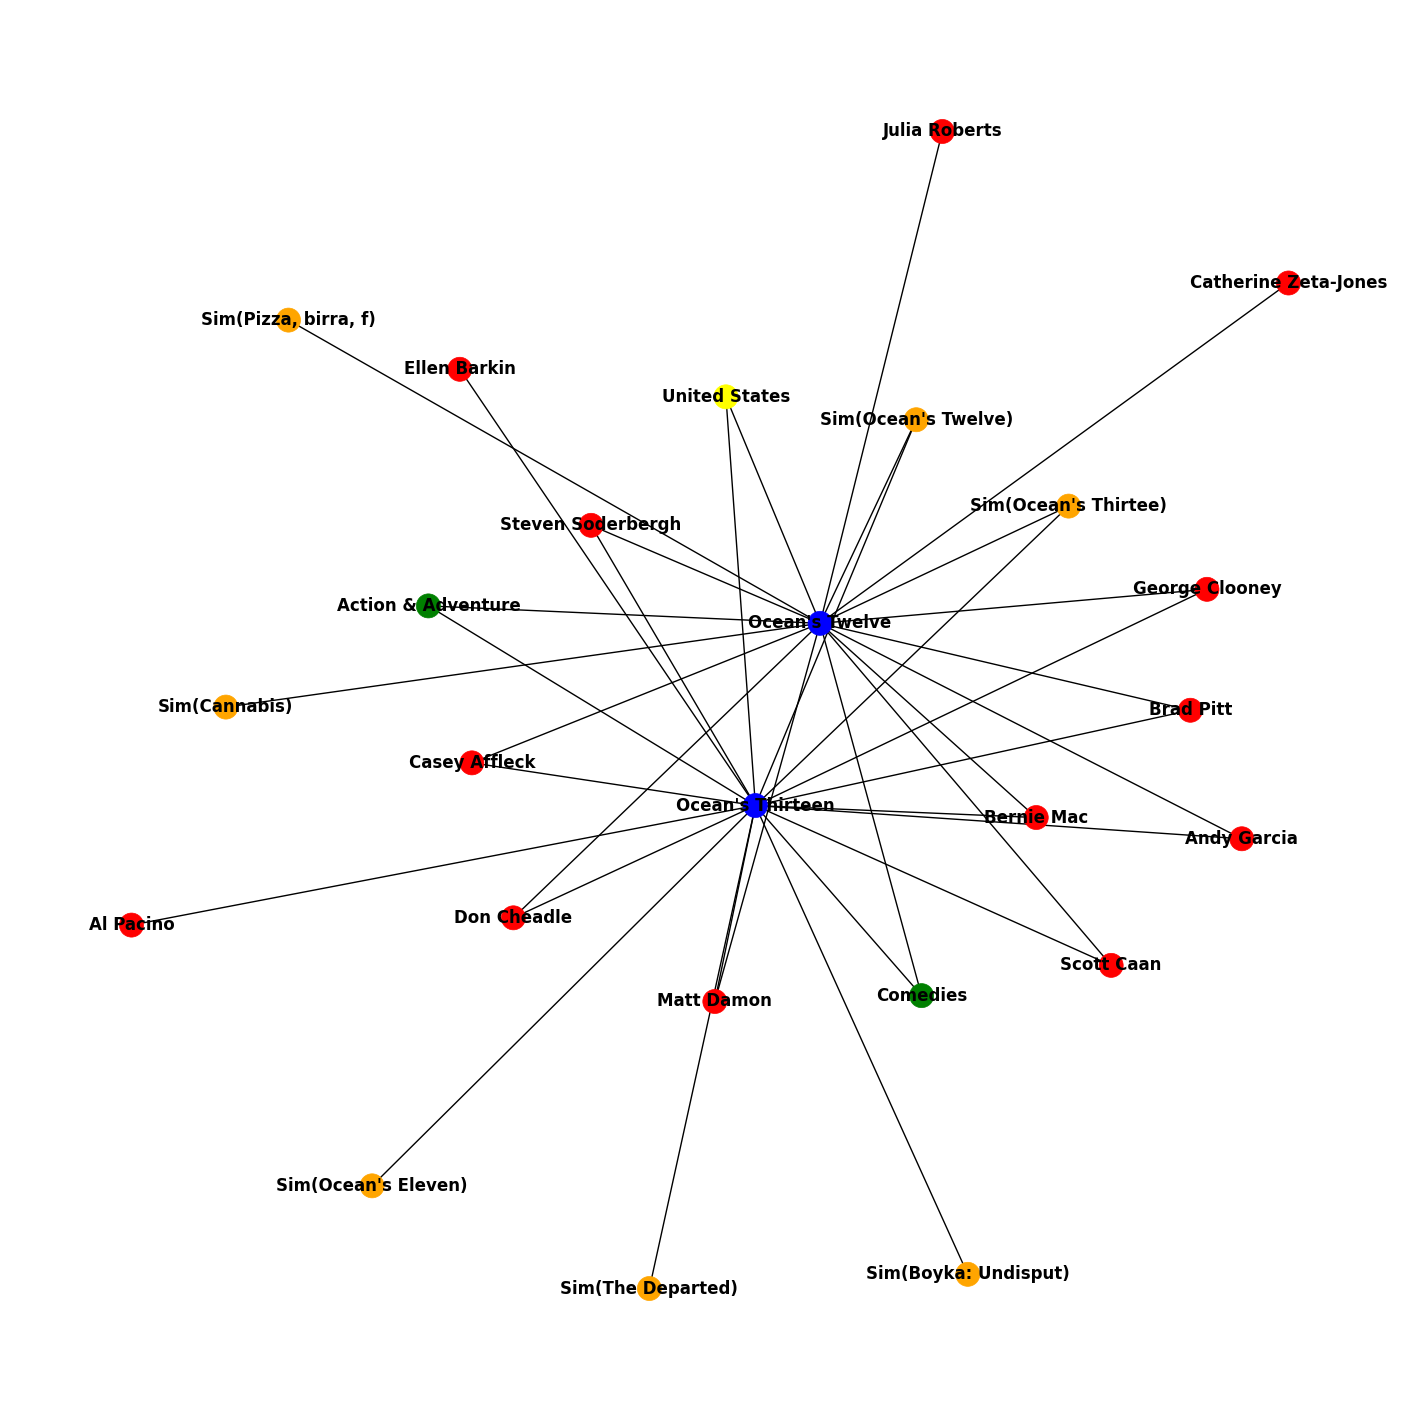

In [36]:
# 입력된 리스트의 노드들의 모든 인접 노드를 가져오는 함수
def get_all_adj_nodes(list_in):
    sub_graph = set()  # 노드를 저장할 빈 집합을 초기화
    # 입력된 리스트의 각 노드에 대해 반복
    for m in list_in:
        sub_graph.add(m)  # 현재 노드를 서브그래프에 추가
        # 주어진 그래프 G에서 현재 노드의 이웃을 반복
        for e in G.neighbors(m):        
            sub_graph.add(e)  # 이웃을 서브그래프에 추가
    return list(sub_graph)  # 집합을 리스트로 변환하여 반환

# 서브그래프를 그리는 함수
def draw_sub_graph(sub_graph):
    # 주어진 노드와 레이블을 기반으로 주어진 그래프의 서브그래프를 생성
    subgraph = G.subgraph(sub_graph)
    colors = []  # 노드 색상을 레이블에 따라 저장할 리스트
    # 서브그래프의 노드를 반복
    for e in subgraph.nodes():
        # 각 노드의 레이블에 따라 색상을 할당
        if G.nodes[e]['label'] == "MOVIE":
            colors.append('blue')
        elif G.nodes[e]['label'] == "PERSON":
            colors.append('red')
        elif G.nodes[e]['label'] == "CAT":
            colors.append('green')
        elif G.nodes[e]['label'] == "COU":
            colors.append('yellow')
        elif G.nodes[e]['label'] == "SIMILAR":
            colors.append('orange')    
        elif G.nodes[e]['label'] == "CLUSTER":
            colors.append('orange')

    # 노드 레이블과 사용자 지정 노드 색상으로 서브그래프 그리기 
    nx.draw(subgraph, with_labels=True, font_weight='bold', node_color=colors)
    plt.show()

# 예제 사용법
list_in = ["Ocean's Twelve", "Ocean's Thirteen"]
sub_graph = get_all_adj_nodes(list_in)  # 입력된 리스트의 인접 노드 가져오기
draw_sub_graph(sub_graph)  # 서브그래프 그리기


In [28]:
import math
import pandas as pd

# root 노드에 대한 추천을 제공하는 함수
def get_recommendation(root):
    commons_dict = {}  # 영화와 이웃 노드들 간의 공통 관심사를 저장할 사전
    # root 노드의 이웃들에 대해 반복합니다.
    for e in G.neighbors(root):
        # 각 이웃 노드의 이웃들에 대해 반복
        for e2 in G.neighbors(e):
            if e2 == root:  # root 자체는 무시
                continue
            if G.nodes[e2]['label'] == "MOVIE":  # 이웃 노드가 영화 노드인 경우
                commons = commons_dict.get(e2)
                if commons == None:  # 해당 영화와 공통으로 본 영화가 없는 경우
                    commons_dict.update({e2: [e]})
                else:
                    commons.append(e)
                    commons_dict.update({e2: commons})

    movies = []  # 영화 리스트
    weight = []  # 가중치 리스트
    # 영화별로 가중치를 계산
    for key, values in commons_dict.items():
        w = 0.0
        for e in values:
            w = w + 1 / math.log(G.degree(e))  # 가중치 계산
        movies.append(key)  # 영화 추가
        weight.append(w)   # 가중치 추가

    # 결과를 시리즈 형태로 반환
    result = pd.Series(data=np.array(weight), index=movies)
    result.sort_values(inplace=True, ascending=False)  # 가중치에 따라 정렬
    return result


In [29]:
result = get_recommendation("Ocean's Twelve")
result2 = get_recommendation("Ocean's Thirteen")
result3 = get_recommendation("The Devil Inside")
result4 = get_recommendation("Stranger Things")

# 각각에 대해 추천을 생성 
# 생성된 추천을 출력
print("*"*40+"\n Recommendation for 'Ocean's Twelve'\n"+"*"*40)
print(result.head())
print("*"*40+"\n Recommendation for 'Ocean's Thirteen'\n"+"*"*40)
print(result2.head())
print("*"*40+"\n Recommendation for 'Belmonte'\n"+"*"*40)
print(result3.head())
print("*"*40+"\n Recommendation for 'Stranger Things'\n"+"*"*40)
print(result4.head())

****************************************
 Recommendation for 'Ocean's Twelve'
****************************************
Ocean's Thirteen     7.575565
Ocean's Eleven       1.542593
The Informant!       1.346214
Babel                1.199195
The Mask of Zorro    1.194038
dtype: float64
****************************************
 Recommendation for 'Ocean's Thirteen'
****************************************
Ocean's Twelve       7.575565
Ocean's Eleven       2.100704
The Departed         1.698527
Brooklyn's Finest    1.492545
Boyka: Undisputed    1.400020
dtype: float64
****************************************
 Recommendation for 'Belmonte'
****************************************
The Devil and Father Amorth              1.423117
Making a Murderer                        1.243407
Belief: The Possession of Janet Moses    1.116221
The Autopsy of Jane Doe                  1.032475
The Diabolical                           1.032475
dtype: float64
****************************************
 Recommenda

In [42]:
df=pd.read_csv('judicial_precedent_All_encoding.csv')[:1000]
df.head()

,판례일련번호,사건명,사건번호,선고일자,법원명,사건종류명,사건종류코드,판결유형,선고,판례상세링크,법원종류코드,판시사항,판결요지,참조조문,참조판례,판례내용
0,238193,손해배상(기),2023다246600,2023.12.07,대법원,민사,400101.0,판결,선고,/DRF/lawService.do?OC=dbs313&target=prec&ID=23...,400201.0,집합건물의 시공자의 분양자에 대한 하자보수를 갈음하는 손해배상채무의 소멸시효가 ...,집합건물의 소유 및 관리에 관한 법률(이하 ‘집합건물법’이라 한다) 제9조 제1항은...,"집합건물의 소유 및 관리에 관한 법률 제9조 제1항, 제2항, 제3항, 민법 제66...",NaN,"【원고, 피상고인】 ○○아파트 입주자대표회의 (소송대리인 법무법인 중추 담당변호사 ..."
1,238199,근로기준법위반·근로자퇴직급여보장법위반,2020도15393,2023.12.07,대법원,형사,400102.0,판결,선고,/DRF/lawService.do?OC=dbs313&target=prec&ID=23...,400201.0,[1] 구 근로기준법상 ‘1주간의 연장근로가 12시간을 초과하였는지’는 근로시간이...,[1] 구 근로기준법(2017. 11. 28. 법률 제15108호로 개정되기 전의 ...,[1] 구 근로기준법(2017. 11. 28. 법률 제15108호로 개정되기 전의...,[1] 대법원 2013. 12. 18. 선고 2012다89399 전원합의체 판결(...,【피 고 인】 피고인<br/>【상 고 인】 피고인<br/>【변 호 인】 변호사 신열...
2,238197,건물인도,2022다279795,2023.12.07,대법원,민사,400101.0,판결,선고,/DRF/lawService.do?OC=dbs313&target=prec&ID=23...,400201.0,[1] 임차인의 계약갱신 요구와 이를 거절할 수 있는 사유를 정한 주택임대차보호...,[1] 2020. 7. 31. 법률 제17470호 개정으로 신설된 주택임대차보호...,[1] 주택임대차보호법 제6조의3 제1항 / [2] 주택임대차보호법 제6조의3 제...,[1] 대법원 2022. 12. 1. 선고 2021다266631 판결(공2023상...,"【원고, 피상고인】 원고<br/>【피고, 상고인】 피고 1 외 1인 (소송대리인 법..."
3,238195,저작권법위반·부정경쟁방지및영업비밀보호에관한법률위반,2020도17863,2023.12.07,대법원,형사,400102.0,판결,선고,/DRF/lawService.do?OC=dbs313&target=prec&ID=23...,400201.0,[1] 저작재산권 침해 여부를 가리기 위하여 두 저작물 사이에 실질적 유사성이 있...,[1] 저작권법이 보호하는 것은 인간의 사상 또는 감정을 말·문자·음·색 등에 의...,"[1] 저작권법 제136조 제1항 제1호 / [2] 저작권법 제20조, 제136조...","[1] 대법원 2010. 2. 11. 선고 2007다63409 판결(공2010상,...",【피 고 인】 피고인<br/>【상 고 인】 피고인<br/>【변 호 인】 법무법인 민...
4,238191,소유권이전등기,2023다269139,2023.12.07,대법원,민사,400101.0,판결,선고,/DRF/lawService.do?OC=dbs313&target=prec&ID=23...,400201.0,[1] 당사자 사이에 계약의 해석을 둘러싸고 이견이 있어 당사자의 의사 해석이 문...,[1] 일반적으로 계약을 해석할 때에는 형식적인 문구에만 얽매여서는 안 되고 쌍방...,"[1] 민법 제105조 / [2] 민법 제536조 / [3] 민법 제2조 제1항,...",[1] 대법원 2021. 3. 25. 선고 2018다275017 판결(공2021상...,"【원고, 상고인】 원고 (소송대리인 법무법인 지온 담당변호사 안민 외 1인)<br/..."


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   판례일련번호  1000 non-null   int64  
 1   사건명     1000 non-null   object 
 2   사건번호    1000 non-null   object 
 3   선고일자    1000 non-null   object 
 4   법원명     1000 non-null   object 
 5   사건종류명   1000 non-null   object 
 6   사건종류코드  1000 non-null   float64
 7   판결유형    1000 non-null   object 
 8   선고      1000 non-null   object 
 9   판례상세링크  1000 non-null   object 
 10  법원종류코드  1000 non-null   float64
 11  판시사항    864 non-null    object 
 12  판결요지    741 non-null    object 
 13  참조조문    864 non-null    object 
 14  참조판례    648 non-null    object 
 15  판례내용    1000 non-null   object 
dtypes: float64(2), int64(1), object(13)
memory usage: 125.1+ KB


In [45]:
# df. info의 type이 object 인 자료만 걸러냄 
object_columns=df.select_dtypes(include=['object']).columns
object_columns

Index(['사건명', '사건번호', '선고일자', '법원명', '사건종류명', '판결유형', '선고', '판례상세링크', '판시사항',
       '판결요지', '참조조문', '참조판례', '판례내용'],
      dtype='object')

In [51]:
field=object_columns[4]
print(field)
len(df[field].value_counts()),df[field].value_counts()

사건종류명


(6,
 민사      493
 형사      278
 일반행정    144
 세무       54
 가사       19
 특허       12
 Name: 사건종류명, dtype: int64)

In [54]:
cate=[]
for field in object_columns:
    tmpData=df[field].value_counts()
    print(field,'-->',len(tmpData))
    if len(tmpData)<40:
        cate.append(field)
cate

사건명 --> 628
사건번호 --> 999
선고일자 --> 160
법원명 --> 38
사건종류명 --> 6
판결유형 --> 9
선고 --> 2
판례상세링크 --> 1000
판시사항 --> 840
판결요지 --> 676
참조조문 --> 830
참조판례 --> 588
판례내용 --> 1000


['법원명', '사건종류명', '판결유형', '선고']

In [59]:
df['판례내용'][0].split('【이    유】')[1]

'  상고이유를 판단한다.<br/>  1. 사안의 개요<br/>  원심판결의 이유와 기록에 의하면 다음과 같은 사실을 알 수 있다.<br/>  가. 원고는 이 사건 아파트의 입주자대표회의이고, 피고 양우건설 주식회사(이하 ‘피고 양우건설’이라 한다)는 이 사건 아파트를 건축한 시공자이며, 피고 건양디앤씨 주식회사(이하 ‘피고 건양디앤씨’라 한다)는 이 사건 아파트를 분양한 분양자이다.<br/>  나. 원고는 이 사건 아파트 구분소유자 일부로부터 피고들에 대한 하자보수를 갈음하는 손해배상채권을 양수하였고, 피고들에게 채권양도 통지를 하였다. <br/>  다. 이에 따라 원고는 피고들을 상대로 하자보수를 갈음하는 손해배상을 청구하는 이 사건 소를 제기하였다. 피고 양우건설은 분양자인 피고 건양디앤씨가 시공자인 피고 양우건설에게 가지는 하자보수를 갈음하는 손해배상청구권이 소멸시효 완성으로 소멸하였으므로, 「집합건물의 소유 및 관리에 관한 법률」(이하 ‘집합건물법’이라 한다) 제9조 제2항에 따라 이 부분에 대하여 원고에게 책임을 부담하지 않는다고 주장하였다. <br/>  2. 피고 양우건설의 상고이유에 대한 판단<br/>  가. 집합건물법 제9조 제1항은 "제1조 또는 제1조의2의 건물을 건축하여 분양한 자(이하 ‘분양자’라 한다)와 분양자와의 계약에 따라 건물을 건축한 자로서 대통령령으로 정하는 자(이하 ‘시공자’라 한다)는 구분소유자에 대하여 담보책임을 진다. 이 경우 그 담보책임에 관하여는 민법 제667조 및 제668조를 준용한다."라고 규정하고 있다. 이에 따라 시공자는 구분소유자에게 하자보수를 갈음하는 손해배상채무(이하 ‘제1 채무’라 한다)를 부담한다. <br/>  나. 집합건물법 제9조 제2항은 "제1항에도 불구하고 시공자가 분양자에게 부담하는 담보책임에 관하여 다른 법률에 특별한 규정이 있으면 시공자는 그 법률에서 정하는 담보책임의 범위에서 구분소유자에게 제1항의 담보책임을 진다."라고 규정하고 있다. 이에 따라 다른 법률에 시공자의 분양자에 대한 담

In [67]:
numList=[]
for num,x in enumerate(df['판례내용']):
    cnt=len(x.split('【이    유】'))
    if cnt <2:
        numList.append(num)

In [68]:

df.iloc[numList,:]

,판례일련번호,사건명,사건번호,선고일자,법원명,사건종류명,사건종류코드,판결유형,선고,판례상세링크,법원종류코드,판시사항,판결요지,참조조문,참조판례,판례내용


In [69]:
tmpList=[]
for x in df['판례내용']:
    try:
        tmpList.append(x.split('【이    유】')[1])
    except:
        tmpList.append('Nan')

In [71]:
df['이유']=tmpList
df.head(3)

,판례일련번호,사건명,사건번호,선고일자,법원명,사건종류명,사건종류코드,판결유형,선고,판례상세링크,법원종류코드,판시사항,판결요지,참조조문,참조판례,판례내용,이유
0,238193,손해배상(기),2023다246600,2023.12.07,대법원,민사,400101.0,판결,선고,/DRF/lawService.do?OC=dbs313&target=prec&ID=23...,400201.0,집합건물의 시공자의 분양자에 대한 하자보수를 갈음하는 손해배상채무의 소멸시효가 ...,집합건물의 소유 및 관리에 관한 법률(이하 ‘집합건물법’이라 한다) 제9조 제1항은...,"집합건물의 소유 및 관리에 관한 법률 제9조 제1항, 제2항, 제3항, 민법 제66...",NaN,"【원고, 피상고인】 ○○아파트 입주자대표회의 (소송대리인 법무법인 중추 담당변호사 ...",상고이유를 판단한다.<br/> 1. 사안의 개요<br/> 원심판결의 이유와 ...
1,238199,근로기준법위반·근로자퇴직급여보장법위반,2020도15393,2023.12.07,대법원,형사,400102.0,판결,선고,/DRF/lawService.do?OC=dbs313&target=prec&ID=23...,400201.0,[1] 구 근로기준법상 ‘1주간의 연장근로가 12시간을 초과하였는지’는 근로시간이...,[1] 구 근로기준법(2017. 11. 28. 법률 제15108호로 개정되기 전의 ...,[1] 구 근로기준법(2017. 11. 28. 법률 제15108호로 개정되기 전의...,[1] 대법원 2013. 12. 18. 선고 2012다89399 전원합의체 판결(...,【피 고 인】 피고인<br/>【상 고 인】 피고인<br/>【변 호 인】 변호사 신열...,상고이유를 판단한다.<br/> 1. 공소사실의 요지와 원심의 판단<br/> ...
2,238197,건물인도,2022다279795,2023.12.07,대법원,민사,400101.0,판결,선고,/DRF/lawService.do?OC=dbs313&target=prec&ID=23...,400201.0,[1] 임차인의 계약갱신 요구와 이를 거절할 수 있는 사유를 정한 주택임대차보호...,[1] 2020. 7. 31. 법률 제17470호 개정으로 신설된 주택임대차보호...,[1] 주택임대차보호법 제6조의3 제1항 / [2] 주택임대차보호법 제6조의3 제...,[1] 대법원 2022. 12. 1. 선고 2021다266631 판결(공2023상...,"【원고, 피상고인】 원고<br/>【피고, 상고인】 피고 1 외 1인 (소송대리인 법...",상고이유를 판단한다.<br/> 1. 사안의 개요 및 원심의 판단 <br/> ...


In [77]:
import collections
temp_list=[]
dataList=[]
for sentence in df['이유']:
 s_list=okt.pos(sentence)
 dataList.append(s_list)
 for word,tag in s_list:
   if tag in ['Noun','Adjective']:
     temp_list.append(word)
counts=collections.Counter(temp_list)
tag=counts.most_common(50)
tag

[('제', 28349),
 ('이', 22802),
 ('사건', 18576),
 ('등', 14076),
 ('원고', 13163),
 ('것', 12179),
 ('수', 10967),
 ('피고', 10770),
 ('그', 10291),
 ('위', 9817),
 ('관', 9063),
 ('판결', 8994),
 ('이유', 8519),
 ('판단', 7940),
 ('및', 7276),
 ('항', 7191),
 ('원심', 7023),
 ('피고인', 6860),
 ('경우', 6181),
 ('대한', 5963),
 ('있다', 5935),
 ('사실', 5839),
 ('소외', 5701),
 ('같은', 5047),
 ('규정', 4961),
 ('있는', 4623),
 ('법', 4580),
 ('인정', 4465),
 ('계약', 4376),
 ('부분', 4209),
 ('행위', 4170),
 ('해당', 4121),
 ('의', 3895),
 ('주장', 3886),
 ('정', 3812),
 ('상고', 3775),
 ('없다', 3772),
 ('선고', 3735),
 ('각', 3693),
 ('대법원', 3564),
 ('피해자', 3484),
 ('법리', 3452),
 ('대하', 3436),
 ('지급', 3415),
 ('이하', 3377),
 ('관련', 3353),
 ('중', 3328),
 ('구', 3229),
 ('점', 2968),
 ('사정', 2956)]

In [83]:
temp_list

['상고',
 '이유',
 '판단',
 '사안',
 '개요',
 '심판',
 '결의',
 '이유',
 '기록',
 '의하면',
 '다음',
 '같은',
 '사실',
 '알',
 '수',
 '있다',
 '원고',
 '이',
 '사건',
 '아파트',
 '입주자',
 '대표',
 '회의',
 '피고',
 '양우',
 '건설',
 '주식회사',
 '이하',
 '피고',
 '양우',
 '건설',
 '이',
 '사건',
 '아파트',
 '건축',
 '공자',
 '피고',
 '건양',
 '디앤',
 '주식회사',
 '이하',
 '피고',
 '건양',
 '디앤',
 '이',
 '사건',
 '아파트',
 '분양',
 '분양',
 '나',
 '원고',
 '이',
 '사건',
 '아파트',
 '구분',
 '소유자',
 '부로',
 '피고',
 '대한',
 '하자',
 '보수',
 '손해배상',
 '채권',
 '양수',
 '피고',
 '채권양도',
 '통지',
 '이',
 '원고',
 '피고',
 '상대로',
 '하자',
 '보수',
 '손해배상',
 '청구',
 '이',
 '사건',
 '소',
 '제기',
 '피고',
 '양우',
 '건설',
 '분양',
 '피고',
 '건양',
 '디앤',
 '공자',
 '피고',
 '양우',
 '건설',
 '하자',
 '보수',
 '손해배상청구권',
 '소멸시효',
 '완성',
 '소멸하였으므로',
 '집합',
 '건물',
 '소유',
 '및',
 '관리',
 '관',
 '법률',
 '이하',
 '집합건물법',
 '제',
 '제',
 '항',
 '이',
 '부분',
 '대하',
 '원고',
 '책임',
 '부담',
 '주장',
 '피고',
 '양우',
 '건설',
 '상고',
 '이유',
 '대한',
 '판단',
 '집합건물법',
 '제',
 '제',
 '항',
 '제',
 '제',
 '의',
 '건물',
 '건축',
 '분양',
 '자',
 '이하',
 '분양',
 '분양',
 '계약',
 '건물',
 '건축',
 '자로',
 '대통령령'

In [ ]:
tokens_str = []
for text in df['이유']:
    pos = okt.pos(text)
    tokens = [word for word, tag in pos if tag in ('Noun', 'Adjective')]
    tokens_str.append(' '.join(tokens))

# 데이터 프레임 생성
df = pd.DataFrame({'original_text': df['이유'], 'tokens': tokens_str})

print(df)